In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from skimage import img_as_ubyte
import imageio
import json
import cv2
import time
from PIL import Image
from pytorch3d.loss import (
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch.nn.functional as F

from tqdm import tqdm_notebook
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj
import math
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures, join_meshes_as_batch
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    SfMPerspectiveCameras,
    PointLights, 
    BlendParams,
    DirectionalLights,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    SoftPhongShader,
    MeshRasterizer,  
    HardPhongShader,
    TexturedSoftPhongShader,
    SoftSilhouetteShader,
    look_at_rotation,
    HardFlatShader
)

# add path for demo utils functions 
import sys
import os
import glob
sys.path.append(os.path.abspath(''))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
def now_str():
    now = datetime.now()
    month = str(now.month)
    day = str(now.day)
    hour = str(now.hour)
    minute = str(now.minute)
    sec = str(now.second)
    
    output = '[{:>02}/{:>02} {:>02}:{:>02}:{:>02}]'.format(month, day, hour, minute, sec)
    return output
def __output_log(path, strs):
    if not os.path.exists(path):
        with open(path, 'w+') as f:
            f.write(strs)
            f.close()
    else:
        with open(path, 'a+') as f:
            f.write(strs)
            f.close()
def get_path(func):  
    if type(func).__name__ == 'function' : 
        return func.__code__.co_filename
    else: 
        raise ValueError("'func' must be a function") 


def draw_triangle(p, v1, v2, v3):
    p.plot([v1[0], v2[0]], [v1[1], v2[1]], c='r')
    p.plot([v2[0], v3[0]], [v2[1], v3[1]], c='g')
    p.plot([v3[0], v1[0]], [v3[1], v1[1]], c='b')
print(now_str())
print(torch.__version__)
print(torch.version.cuda)
print(get_path(load_obj))


import sys
sys.path.append(r'D:\1_Projects\200325_PyTorch3d_Projects')
import laplacian_pyramid
from laplacian_pyramid import *

[06/08 01:12:16]
1.4.0
9.2
d:\1_projects\200323_pytorch3dstart\pytorch3d\io\obj_io.py


In [2]:
print('torch.cuda.is_available():',torch.cuda.is_available())

device = torch.device("cuda:0")
torch.cuda.set_device(device)
print('----- torch.cuda.empty_cache() -----')

torch.cuda.empty_cache()
bytes_reserved = torch.cuda.memory_reserved()
print('torch.cuda.memory_reserved(): {:,.2f} Mb'.format(bytes_reserved * 0.000001))
bytes_alloc = torch.cuda.memory_allocated()
print('torch.cuda.memory_allocated(): {:,.2f} Mb'.format(bytes_alloc * 0.000001))
bytes_cached = torch.cuda.memory_cached()
print('torch.cuda.memory_cached(): {:,.2f} Mb'.format(bytes_cached * 0.000001))

torch.cuda.is_available(): True
----- torch.cuda.empty_cache() -----
torch.cuda.memory_reserved(): 0.00 Mb
torch.cuda.memory_allocated(): 0.00 Mb
torch.cuda.memory_cached(): 0.00 Mb


# settings

In [3]:
p_image_sizes = [256]
p_parameter_types = ['verts_deform']
p_num_cams = [16]
p_batch_size = [8]
p_use_texture = [True]
p_target_offset_dist = [0.0] # -1: random deform
p_blur_radius = [1e-4]
p_faces_per_pixel = [1]
p_texturemap_size = [16]
p_sigma = [1e-4]
p_gamma = [1e-4]
p_use_scheduler = [True]
p_resize_methods = ['interpolate']
p_loss_type = ['rgba']
# p_loss_type = ['a']

assert(len(p_batch_size) == len(p_num_cams))
p_params = []
lr = 0.005

for _, param_type in enumerate(p_parameter_types):
    for _, resize_method in enumerate(p_resize_methods):
        for _, image_size in enumerate(p_image_sizes):
            for i2, num_cams in enumerate(p_num_cams):
                for _, use_texture in enumerate(p_use_texture):
                    for _, texturemap_size in enumerate(p_texturemap_size):
                        for _, loss_type in enumerate(p_loss_type):
                            for _, target_offset in enumerate(p_target_offset_dist):
                                for _, blur_radius in enumerate(p_blur_radius):
                                    for _, faces_per_pixel in enumerate(p_faces_per_pixel):
                                        for _, sigma in enumerate(p_sigma):
                                            for _, gamma in enumerate(p_gamma):
                                                for _, use_scheduler in enumerate(p_use_scheduler):
                                                    p_params.append(
                                                        {
                                                         'index': len(p_params),
                                                         'nnParameter_type': param_type,
                                                         'image_size': image_size,
                                                         'num_cams': num_cams,
                                                         'resize_method': resize_method,
                                                         'batch_size': p_batch_size[i2],
                                                         'use_texture': use_texture,
                                                         'texturemap_size': texturemap_size,
                                                         'loss_type': loss_type,
                                                         'faces_per_pixel': faces_per_pixel,
                                                         'target_offset': target_offset,
                                                         'blur_radius': blur_radius,
                                                         'sigma': sigma,
                                                         'gamma': gamma,
                                                         'lr': lr,
                                                         'use_scheduler': use_scheduler}
                                                        )
print('{} settings'.format(len(p_params)))
def params2string(idx, n_settings, p):
    str_out = '--- [Setting {}/{}] ----------------------\n'.format(idx + 1, n_settings)
    i = 1
    for k, v in p.items():
        if type(v) == str:
            str_out += '{:>2}. {:17}= {}'.format(i, k, v)
        elif isinstance(v, int):
            str_out += '{:>2}. {:17}= {:d}'.format(i, k, v)
        else:
            str_out += '{:>2}. {:17}= {:.4f}'.format(i, k, v)
        str_out += '\n'
        i += 1
    str_out += '\n'
    return str_out

setting_idx = 0
param_str = params2string(setting_idx, len(p_params), p_params[setting_idx])
print(param_str)

obj_name = 'sphere'
out_folder_name = '10g_data'

def export_losses(losses, export_dir):
    out_path = export_dir + '/losses.json'
    with open(out_path, 'w+') as f:
        json.dump(losses, f, indent=4)
    print('losses exported to:', out_path)
    
def export_params(params, export_dir):
    out_path = export_dir + '/parameters.json'
    with open(export_dir + '/parameters.json', 'w+') as f:
        json.dump(params, f, indent=4)
    print('parameters saved to:', out_path)
          
export_dir = './{}/output'.format(out_folder_name)
if not os.path.exists(export_dir):
    os.mkdir(export_dir)
export_dir += '/' + obj_name
if not os.path.exists(export_dir):
    os.mkdir(export_dir)


1 settings
--- [Setting 1/1] ----------------------
 1. index            = 0
 2. nnParameter_type = verts_deform
 3. image_size       = 256
 4. num_cams         = 16
 5. resize_method    = interpolate
 6. batch_size       = 8
 7. use_texture      = 1
 8. texturemap_size  = 16
 9. loss_type        = rgba
10. faces_per_pixel  = 1
11. target_offset    = 0.0000
12. blur_radius      = 0.0001
13. sigma            = 0.0001
14. gamma            = 0.0001
15. lr               = 0.0050
16. use_scheduler    = 1




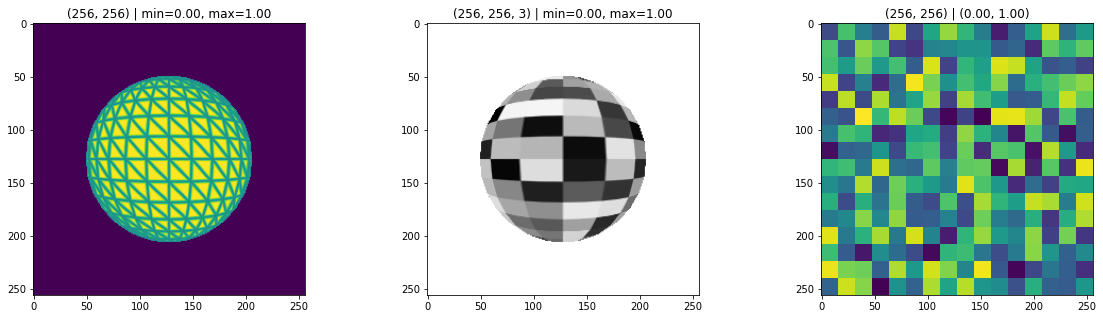

In [4]:
def gen_mesh(mesh_path, device, s, deform=False):
    verts, faces, aux = load_obj(mesh_path)
    use_texturemap = s['use_texture']
    target_offset = s['target_offset']
    np.random.seed(111*len(verts))
    
    faces_idx = faces.verts_idx
    if use_texturemap:
        image_size = s['image_size']
        texturemap_size = s['texturemap_size']
        texturemap_shape = (texturemap_size, texturemap_size, 1)
#         texturemap_np = np.random.rand(texturemap_shape[0], texturemap_shape[1], 3).astype(np.float32)
        texturemap_np = np.random.rand(texturemap_shape[0], texturemap_shape[1], 1).astype(np.float32)
        # texturemap_np = Image.open('./1_data/cow_mesh' + '/cow_texture.png')
        # texturemap_np = texturemap_np.convert('RGB')
        texturemap_np = np.asarray(texturemap_np).astype(np.float32)
        texturemap_np = cv2.resize(texturemap_np, (image_size, image_size), interpolation=cv2.INTER_NEAREST)
#         texturemap_np = cv2.resize(texturemap_np, (raster_settings.image_size, raster_settings.image_size), interpolation=cv2.INTER_LINEAR)
        texturemap_np = np.expand_dims(np.expand_dims(texturemap_np, axis=0), axis=-1)
        # texturemap_np /= 255.0
        texture_map_torch = torch.from_numpy(texturemap_np).to(device)
        texture_map = nn.Parameter(texture_map_torch, requires_grad=False)
        verts_uvs = aux.verts_uvs[None, ...].to(device)  # (1, V, 2)
        faces_uvs = faces.textures_idx[None, ...].to(device)  # (1, F, 3)
        verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
        
        textures = Textures(maps=texture_map, faces_uvs=faces_uvs, verts_uvs=verts_uvs, verts_rgb=verts_rgb.to(device)).to(device)
    else:
        verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
        verts_rgb[:, 0, :] = torch.tensor([1.0, 0.0, 0.0])
        verts_rgb[:, 1, :] = torch.tensor([0.0, 1.0, 0.0])
        verts_rgb[:, 2, :] = torch.tensor([0.0, 0.0, 1.0])
#         verts_rgb[:, 1, :] = torch.tensor([0.0, 1.0, 0.0])
#         verts_rgb[:, 2, :] = torch.tensor([0.0, 0.0, 1.0])
        if verts_rgb.shape[1] > 3:
#             verts_rgb[:, 3, :] = torch.tensor([1.0, 1.0, 0.0])
            verts_rgb[:, 3, :] = torch.tensor([1.0, 0.0, 0.0])

        textures = Textures(verts_rgb=verts_rgb.to(device)).to(device)

    # Create a Meshes object for the teapot. Here we have only one mesh in the batch.
    mesh = Meshes(
        verts=[verts.to(device)],   
        faces=[faces_idx.to(device)], 
        textures=textures
    )

    # deform mesh
    if deform:
        verts = mesh.verts_packed().detach().cpu().numpy()
        if target_offset < 0:
            dverts_target = (np.random.rand(verts.shape[0], 3).astype(np.float32) - 0.5)
        else:
            dverts_target = np.zeros((verts.shape[0], 3)).astype(np.float32)
            dverts_target = dverts_target.astype(np.float32)
            dverts_target = dverts_target + np.array([target_offset, target_offset, 0.0]).astype(np.float32)
        dverts_target = torch.from_numpy(dverts_target).to(device)
        mesh = mesh.offset_verts(dverts_target)
    return mesh

distance = 3   # distance from camera to the object
elevation = 0.0   # angle of elevation in degrees
azimuth = 180.0  # No rotation so the camera is positioned on the +Z axis. 
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
raster_settings = RasterizationSettings(
    image_size=p_image_sizes[0], 
    blur_radius=0.0, #np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=1, 
)
lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
a_diffuse = 0.0
a_ambient = 1.0
s = torch.from_numpy(np.zeros((1, 3)).astype(np.float32)).to(device)
d = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_diffuse).to(device)
a = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_ambient).to(device)
lights.specular_color = s
lights.diffuse_color = d
lights.ambient_color = a


in_dir = './10_data'
mesh_path = in_dir + '/input/{}.obj'.format(obj_name)
param_idx = len(p_params)-1
param_idx = 0
mesh_target = gen_mesh(mesh_path, device, p_params[param_idx], deform=False)

if p_params[param_idx]['use_texture']:
    sample_renderer = MeshRenderer(
        rasterizer=MeshRasterizer(cameras=cameras,raster_settings=raster_settings),
        shader=TexturedSoftPhongShader(device=device, blend_params=blend_params, lights=lights)
    )
else:
    sample_renderer = MeshRenderer(
        rasterizer=MeshRasterizer(cameras=cameras,raster_settings=raster_settings),
        shader=SoftPhongShader(device=device, lights=lights, blend_params=blend_params)
    )
    
image_rendered = sample_renderer(meshes_world=mesh_target).detach().cpu().numpy().squeeze()
silhouette = image_rendered[..., 3]
image_rendered = image_rendered[..., :3]

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].imshow(silhouette)
ax[0].set_title('{} | min={:.2f}, max={:.2f}'.format(silhouette.shape, np.min(silhouette), np.max(silhouette)))
ax[1].imshow(image_rendered)
ax[1].set_title('{} | min={:.2f}, max={:.2f}'.format(image_rendered.shape, np.min(image_rendered), np.max(image_rendered)))
if mesh_target.textures._maps_padded is not None:
    mesh_texturemaps = mesh_target.textures._maps_padded.detach().squeeze().cpu().numpy()
    ax[2].imshow(mesh_texturemaps, vmin=0, vmax=1)
    ax[2].set_title('{} | ({:.2f}, {:.2f})'.format(mesh_texturemaps.shape, np.min(mesh_texturemaps), np.max(mesh_texturemaps)))
else:
    ax[2].axis('off')
plt.show()


In [5]:
def render_plots(return_image, is_cuda, out_dir, e, param_idx, params, cam_idx, model, lr, losses, losses_true, grad_values, grad_norms, image_true, image, image_target):
    loss_type = params[param_idx]['loss_type']
    diff_true = np.abs(image_target-image_true)
    diff      = np.abs(image_target-image     )
    
    if is_cuda:
        max_loss = max(max(losses_true['all']), max(losses['all'])).cpu().numpy()
    else:
        max_loss = max(max(losses_true['all']), max(losses['all']))
    
    fig, ax = plt.subplots(2, 6, figsize=(26, 8), tight_layout=True)
    
    a_stat = ax[0, 0]
    a_tloss = ax[0, 3]
    a_tcurr = ax[0, 1]
    a_tdiff = ax[0, 2]
    a_gradnorm = ax[0, 4]
    a_gradvec1 = ax[0, 5]
    a_target = ax[1, 0]
    a_loss = ax[1, 3]
    a_curr = ax[1, 1]
    a_diff = ax[1, 2]
    a_gradvec2 = ax[1, 5]
    a_gradvec3 = ax[1, 4]
    
    a_tloss.plot(losses_true['all'], linewidth=1, c='r')
    a_tloss.set_title('Epoch {} | lr={}\nTrue losses={:.6f}'.format(e, lr, losses_true['all'][-1]))
    if model.loss_type == 'rgba':
        a_tloss.plot(losses_true['pixel'], linewidth=1, c='g')
        a_tloss.plot(losses_true['silhouette'], linewidth=1, c='b')
        a_tloss.legend(['all', 'rgb', 'a'])
    a_tloss.grid()
    a_tloss.set_ylim(bottom=0, top=max_loss*1.1)
    
    
    a_loss.plot(losses['all'], linewidth=1, c='r')
    a_loss.set_title('hidden losses={:.6f}'.format(losses['all'][-1]))
    if model.loss_type == 'rgba':
        a_loss.plot(losses['pixel'], linewidth=1, c='g')
        a_loss.plot(losses['silhouette'], linewidth=1, c='b')
        a_loss.legend(['all', 'rgb', 'a'])
    a_loss.grid()
    a_loss.set_ylim(bottom=0, top=max_loss*1.1)
    
    if loss_type == 'a':
        a_curr.imshow(image, cmap='gray')
        a_diff.imshow(diff, cmap='gray')
        a_tcurr.imshow(image_true, cmap='gray')
        a_tdiff.imshow(diff_true, cmap='gray')
        a_target.imshow(image_target, cmap='gray')
    else:
        a_curr.imshow(image)
        a_diff.imshow(diff)
        a_tcurr.imshow(image_true)
        a_tdiff.imshow(diff_true)
        a_target.imshow(image_target)
        
    a_curr.set_title('hidden current (camera {}/{})'.format(cam_idx+1, model.n_cams))
    a_tcurr.set_title('True current (camera {}/{})'.format(cam_idx+1, model.n_cams))
    a_target.set_title('target')
    
    a_diff.set_title('hidden difference: [{:.1f}, {:.1f}]'.format(np.min(diff), np.max(diff)))
    a_tdiff.set_title('True difference: [{:.1f}, {:.1f}]'.format(np.min(diff_true), np.max(diff_true)))
    
    param_str = params2string(param_idx, len(params), params[param_idx])
    a_stat.text(0, 0, param_str, fontsize=12)
    a_stat.axis('off')
    
    a_gradnorm.plot(grads, linewidth=1, c='b')
    a_gradnorm.set_title('||grad||={:.6f}'.format(grads[-1]))
    a_gradnorm.grid()
    a_gradnorm.set_ylim(bottom=0)
    
    a_gradvec1.axis('off')
    a_gradvec1 = fig.add_subplot(2, 6, 6, projection='3d')
    verts = model.mesh.verts_packed().detach().cpu().numpy()
    mesh_verts = model.mesh.verts_packed().detach().cpu().numpy()
    if model.nnParameter_type == 'translate':
        verts = np.mean(mesh_verts, axis=0)
        
    a_gradvec1.set_title('mesh gradients: {:.6f}'.format(grad_norms[-1]))
    grad_values /= grad_norms[-1]
    if model.nnParameter_type == 'translate':
        a_gradvec1.quiver(verts[0], verts[1], verts[2], grad_values[0], grad_values[1], grad_values[2], normalize=False, lw=2, color='r')
        a_gradvec1.scatter(verts[0], verts[1], verts[2], c='k', s=10)
    elif model.nnParameter_type == 'verts_deform':
        a_gradvec1.quiver(verts[:,0], verts[:,1], verts[:,2], grad_values[:,0], grad_values[:,1], grad_values[:,2], normalize=False, lw=2, color='b')
    a_gradvec1.scatter(mesh_verts[:,0], mesh_verts[:,1], mesh_verts[:,2], c='k', s=10)
    a_gradvec1.view_init(elev=-90, azim=0)
    a_gradvec1.set_xlabel('x'), a_gradvec1.set_ylabel('y'), a_gradvec1.set_zlabel('z')
    a_gradvec1.quiver(np.array([0, 0, 0]), np.array([0, 0, 0]), np.array([0, 0, 0]), np.array([1, 0, 0]), np.array([0, 1, 0]), np.array([0, 0, 1]), color=['r', 'g', 'b'], linestyle=':', normalize=True, arrow_length_ratio=0)
    L = 1.5
    a_gradvec1.set_xlim([-L, L]), a_gradvec1.set_ylim([-L, L]), a_gradvec1.set_zlim([-L, L])
    
    a_gradvec2.axis('off')
    a_gradvec2 = fig.add_subplot(2, 6, 12, projection='3d')
    a_gradvec2.quiver(np.array([0, 0, 0]), np.array([0, 0, 0]), np.array([0, 0, 0]), np.array([1, 0, 0]), np.array([0, 1, 0]), np.array([0, 0, 1]), color=['r', 'g', 'b'], linestyle=':', normalize=True, arrow_length_ratio=0)
    verts = model.mesh.verts_packed().detach().cpu().numpy()
    mesh_verts = model.mesh.verts_packed().detach().cpu().numpy()
    if model.nnParameter_type == 'translate':
        verts = np.mean(mesh_verts, axis=0)
        
    a_gradvec2.set_title('mesh gradients: {:.6f}'.format(grad_norms[-1]))
    if model.nnParameter_type == 'translate':
        a_gradvec2.quiver(verts[0], verts[1], verts[2], grad_values[0], grad_values[1], grad_values[2], normalize=False, lw=2, color='r')
        a_gradvec2.scatter(verts[0], verts[1], verts[2], c='k', s=10)
    elif model.nnParameter_type == 'verts_deform':
        a_gradvec2.quiver(verts[:,0], verts[:,1], verts[:,2], grad_values[:,0], grad_values[:,1], grad_values[:,2], normalize=False, lw=2, color='b')
    a_gradvec2.scatter(mesh_verts[:,0], mesh_verts[:,1], mesh_verts[:,2], c='k', s=10)
    a_gradvec2.view_init(elev=0, azim=0)
    a_gradvec2.set_xlabel('x'), a_gradvec2.set_ylabel('y'), a_gradvec2.set_zlabel('z')
    a_gradvec2.set_xlim([-L, L]), a_gradvec2.set_ylim([-L, L]), a_gradvec2.set_zlim([-L, L])
    
    a_gradvec3.axis('off')
    out_path = out_dir + '/plot_{}.png'.format(e)
    plt.savefig(out_path, dpi=150)
    plt.close('all')
    
    if return_image:
        return imageio.imread(out_path)
    return None

In [6]:
def render_plots_multires(out_dir, e, param_idx, params, lr, res, cam_idx, images_res, loss_total, loss_res, loss_res_true, grads):
    n_res = len(res)
    fig, ax = plt.subplots(n_res + 1, 5, figsize=(22, n_res*7.75), tight_layout=True)
    a_stat = ax[1, -1]
    
    # stats
    param_str = params2string(param_idx, len(params), params[param_idx])
    a_stat.text(0, 0, param_str, fontsize=12)
    a_stat.axis('off')

    # true target, image, diff
    a_loss = ax[0, 0]
    a_img_target = ax[0, 1]
    a_img_curr = ax[0, 2]
    a_img_diff = ax[0, 3]
    a_grad_norm = ax[0, 4]

    i = n_res-1
    legends = []
    for k, v in loss_total.items():
        a_loss.plot(v)
        legends.append(k)
    a_loss.grid(True)
    a_loss.set_xlabel('epoch')
    a_loss.set_ylim(bottom=0)
    a_loss.set_xlim(left=0)
    a_loss.legend(legends)
    a_loss.set_title('Losses combined ({:.6f}) | lr={:.6f}'.format(loss_total['all'][-1], lr))
    
    if params[param_idx]['num_cams'] < 2:
        img_true = images_res[i]['images_true'][..., :3]
        img_target = images_res[i]['target_images_true'][..., :3]
        img_diff = np.abs(img_true - img_target)
    else:
        img_true = images_res[i]['images_true'][cam_idx][..., :3]
        img_target = images_res[i]['target_images_true'][cam_idx][..., :3]
        img_diff = np.abs(img_true - img_target)
    a_img_target.imshow(img_target)
    a_img_curr.imshow(img_true)
    a_img_diff.imshow(img_diff)
    
    a_img_target.set_title('Target {}'.format(img_target.shape))
    a_img_curr.set_title('True current {}'.format(img_true.shape))
    a_img_diff.set_title('True Difference {}'.format(img_diff.shape))
    
    a_grad_norm.plot(grads)
    a_grad_norm.set_title('Gradient norms ({:.6f})'.format(grads[-1]))
    a_grad_norm.grid(True)
    a_grad_norm.set_xlim(left=0)
    a_grad_norm.set_ylim(bottom = 0)
    a_grad_norm.set_xlabel('epoch')
    
    for res_idx in range(n_res-1, -1, -1):
        l = loss_res[res_idx]
        
        imgs = images_res[res_idx]
    
        i = (len(ax)-1) - res_idx
        a_loss = ax[i, 0]
        a_img_target = ax[i, 1]
        a_img_curr = ax[i, 2]
        a_img_diff = ax[i, 3]
        a_empty = ax[i, 4]
        
        
        for k, v in l.items():
            a_loss.plot(v)
            
        a_loss.grid(True)
        a_loss.set_xlabel('epoch')
        a_loss.set_ylim(bottom=0)
        a_loss.set_xlim(left=0)
        a_loss.legend(legends)
        a_loss.set_title('Loss({:.6f}) | res: {:.2f}'.format(l['all'][-1], res[res_idx]))
        
        if params[param_idx]['num_cams'] < 2:
            img = images_res[res_idx]['images']
            img_target = images_res[res_idx]['target_images']
        else:
            img = images_res[res_idx]['images'][cam_idx]
            img_target = images_res[res_idx]['target_images'][cam_idx]
            
        img_diff = np.abs(img-img_target)
        a_img_target.imshow(img_target)
        alpha_curr = img[..., 3]
        a_img_curr.imshow(img)
        a_img_diff.imshow(img_diff)
        a_img_target.set_title('Target {}'.format(img_target.shape))
        a_img_curr.set_title('Hidden current {}, alpha=({:.2f}, {:.2f})'.format(img.shape, np.min(alpha_curr), np.max(alpha_curr)))
        a_img_diff.set_title('Hidden Difference {}'.format(img_diff.shape))
        
        a_empty.axis(False)
    out_path = out_dir + '/plot_{}.png'.format(e)
    plt.savefig(out_path, dpi=150)
    plt.close('all')
    
    return imageio.imread(out_path)



In [70]:
# ================ #
# plot
# ================ #
e = 0
cam_idx = 0
return_image = True
plot_image = render_plots_multires(out_dir, e, param_idx, p_params, model.res, cam_idx, images_res, loss_total, loss_res_all, loss_res_true_all, grads)
plt.figure(figsize=(30, 30))
plt.imshow(plot_image)
plt.axis('off')
plt.show()

TypeError: render_plots_multires() missing 1 required positional argument: 'grads'

In [192]:
# class ResizeConv2d(nn.Module):
#     def __init__(self, device, kernel_size, batch_size, channels=4):
#         super().__init__()
#         self.device = device
#         self.batch_size = batch_size
#         self.kernel_size = kernel_size
#         self.channels = channels
#         self.resize_kernel = self._generate_kernel(batch_size=batch_size, kernel_size=kernel_size, channels=channels)
        
#     def forward(self, x):
#         if self.kernel_size < 2:
#             return x
#         x = x.transpose(1, 3)
#         out = self.resize_kernel(x)
#         return out.transpose(3, 1)
    
#     def _generate_kernel(self, batch_size, kernel_size, channels=4):
#         # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
#         kernel = nn.Conv2d(channels, channels, kernel_size, kernel_size, 0).to(self.device) # ( input_c, output_c, k_size, stride, padding ), k_size can be (3,3) or 3 
#         weight = torch.ones_like(kernel.weight)
#         print('weight:', weight.shape)
#         sum1 = torch.sum(torch.sum(weight, dim=-1), dim=-1)
#         sum2 = torch.sum(weight, dim=3)
#         print('sum1:', sum1.shape, ', sum2:', sum2.shape)
#         weight = weight / torch.sum(weight)
#         kernel.weight = torch.nn.Parameter(weight, requires_grad=False) # a single 3 x 3 kernel
# #         kernel = xy_grid # shape (kernel_size, kernel_size)
# #         # Make sure sum of values in gaussian kernel equals 1.
        
# #         # Reshape to 2d depthwise convolutional weight
# #         kernel = kernel.view(1, 1, kernel_size, kernel_size)
# #         kernel = kernel.repeat(1, channels, 1, 1).to(self.device) # shape (batch_size, channels, kernel_size, kernel_size)
# #         kernel = kernel / torch.sum(kernel)
#         print('  kernel:', kernel)
#         return kernel

1/1
batch_size: 8
self.n_batch: 2
res: 1.0 | 3
   torch.Size([8, 256, 256, 3])
   torch.Size([8, 128, 128, 3])
   torch.Size([8, 64, 64, 3])
res: 1.0 | 3
   torch.Size([8, 256, 256, 3])
   torch.Size([8, 128, 128, 3])
   torch.Size([8, 64, 64, 3])


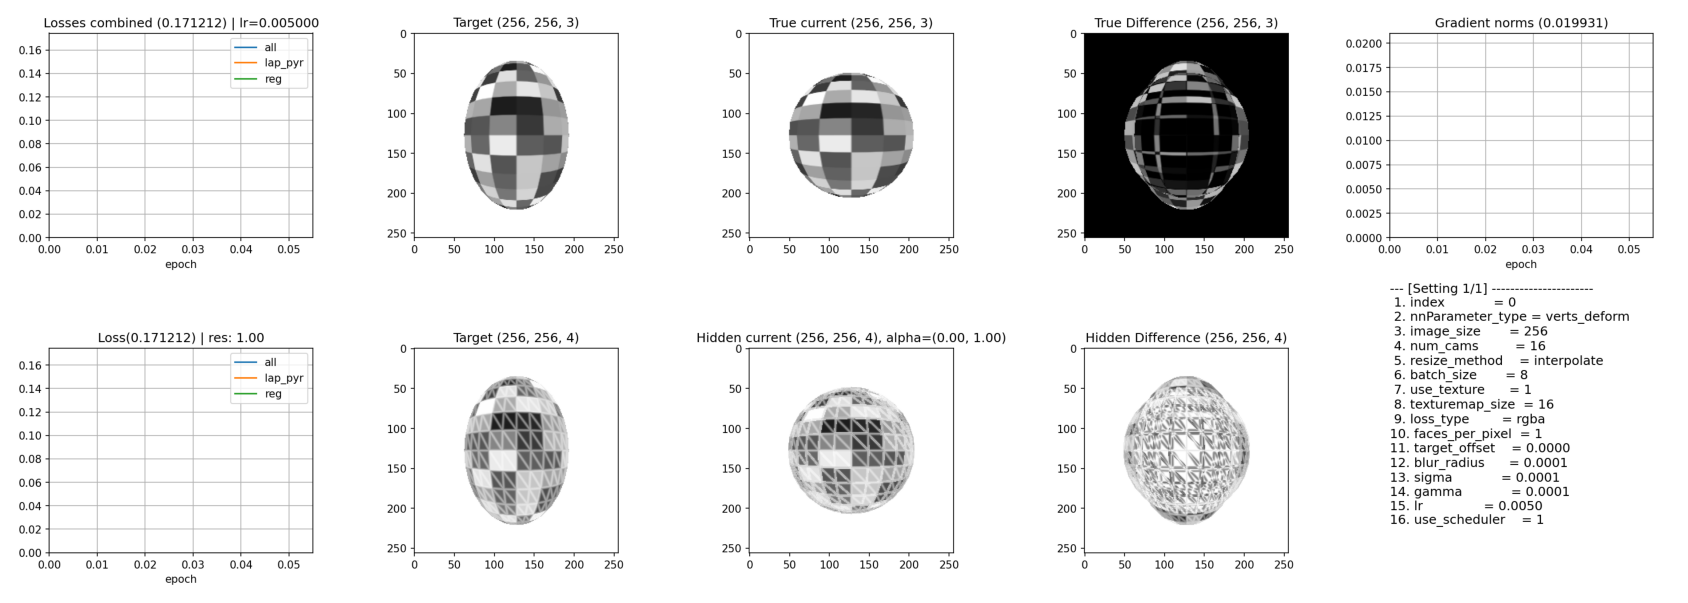

In [107]:
class Model(nn.Module):
    def __init__(self, device, **kwargs):
        super().__init__()
        
        # multi-res for both target image & current image
        self.res = kwargs.get('res', None)
        self.resize_method = kwargs.get('resize_method', None)
        
        
        self.device = device
        self.n_cams = kwargs.get('n_cams', None)
        self.cameras = None
        self.nnParameter_type = kwargs.get('nnParameter_type', None)
        self.image_size = kwargs.get('image_size', None)
        self.mesh = kwargs.get('mesh', None)
        self.mesh_target = kwargs.get('mesh_target', None)
        
        self.blend_params_for_loss = BlendParams(sigma=1e-4, gamma=1e-4)
        self.raster_settings_for_loss = RasterizationSettings(
            image_size=self.image_size, 
            blur_radius=0,
            faces_per_pixel=1, 
        )
        
        self.use_texture = kwargs.get('use_texture', None)
        self.loss_type = kwargs.get('loss_type', None)
        self.batch_size = kwargs.get('batch_size', None)
        self.n_batch = int(self.n_cams / self.batch_size)
        print('self.n_batch:' , self.n_batch)
        self.camera_batches = self._init_cameras()
        
        self.renderer, self.renderer_default = self._init_renderers()
        self.interpolate_mode = 'bilinear'
        self.target_image_batches, self.target_image_batches_true = self._init_target_images()
        
        if self.nnParameter_type == 'translate':
            self.center_offset = torch.from_numpy(np.zeros((3), dtype=np.float32)).to(self.device)
            self.center_offset = nn.Parameter(self.center_offset, requires_grad=True)
            self.dverts = None
        elif self.nnParameter_type == 'verts_deform':
            self.dverts = torch.from_numpy(np.zeros((self.mesh.verts_packed().shape), dtype=np.float32)).to(self.device)
            self.dverts = nn.Parameter(self.dverts, requires_grad=True)
            self.center_offset = None
            
        # laplacian pyramids
        self.lap_pyr = LaplacianPyramid(self.device, self.image_size, n_res=3, channels=3, kernel_size=3, alpha=0.45)
        self.laplacian_refs = {}
        for res_name, img_list in self.target_image_batches.items():
            img_batch = torch.cat(img_list, dim=0)[..., :3]
            lap_list, _ = self.lap_pyr.build_laplacian_pyramid(img_batch)
            self.laplacian_refs[res_name] = lap_list
            
        
    def forward(self, batch_idx, res_idx, params):
        res = self.res[res_idx]
        target_images = self.target_image_batches['res'+str(res)][batch_idx]
        target_images_true = self.target_image_batches_true[batch_idx]

        # apply parameters
        self.renderer.shader.blend_params = BlendParams(sigma=params['sigma'], gamma=params['gamma'])
        self.renderer.rasterizer.raster_settings.blur_radius = params['blur_radius']
        self.renderer.rasterizer.raster_settings.faces_per_pixel = params['faces_per_pixel']
    
        if self.resize_method == 'pytorch3d':
            self.renderer.rasterizer.raster_settings.image_size = int(self.image_size * res)
    
        # ==================================================================================== #
        # minibatch training
        i0 = batch_idx*self.batch_size
        i1 = i0 + self.batch_size
        
        # batch preparation
        if self.nnParameter_type == 'translate':
            dverts = []
            for _ in range(self.mesh.verts_packed().shape[0]):
                dverts.append(self.center_offset)
            dverts = torch.stack(dverts)
        elif self.nnParameter_type == 'verts_deform':
            dverts = self.dverts
        mesh_deformed = self.mesh.offset_verts(dverts)
        meshes = mesh_deformed.extend(self.batch_size)
        cam_batch = self.camera_batches[batch_idx]
        
        # render
        images = self.renderer(meshes_world=meshes, cameras=cam_batch)
        images_true = self.renderer_default(meshes_world=meshes, cameras=cam_batch)
        images_true = images_true.detach()

        if self.resize_method == 'interpolate':
            images = images.transpose(1, 3)
            images = F.interpolate(images, scale_factor=res, mode=self.interpolate_mode)
            images = images.transpose(1, 3)
        
        # laplacian pyramid
        pyramids = []
        lap_list, _ = self.lap_pyr.build_laplacian_pyramid(images[..., :3])
        l_lap_pyr = None
        for lap_res_idx in range(len(lap_list)):
            lap_curr = lap_list[lap_res_idx]
            lap_refs = self.laplacian_refs['res'+str(res)][lap_res_idx][i0:i1]
            pyramids.append((lap_refs, lap_curr))
            if l_lap_pyr is None:
                l_lap_pyr = torch.mean(torch.abs(lap_curr - lap_refs))
            else:
                l_lap_pyr += torch.mean(torch.abs(lap_curr - lap_refs))

        # losses
        if self.loss_type == 'a':
            # loss for gradient
            loss_silhouette = torch.mean(torch.abs(images[..., 3] - target_images[..., 3]))
            loss_pixel = -1
#             loss = loss_silhouette
            # true loss
            loss_silhouette_true = torch.mean(torch.abs(images_true[..., 3] - target_images_true[..., 3]))
            loss_true = loss_silhouette_true
            loss_pixel_true = -1
        elif self.loss_type == 'rgb':
            # loss for gradient
            loss_silhouette = -1
            loss_pixel = torch.mean(torch.abs(images[..., :3] - target_images[..., :3]))
#             loss = loss_pixel
            # true loss
            loss_silhouette_true = -1
            loss_pixel_true = torch.mean(torch.abs(images_true[..., :3] - target_images_true[..., :3]))
            loss_true = loss_pixel_true
        elif self.loss_type == 'rgba':
            # loss for gradient
            loss_pixel = torch.mean(torch.abs(images[..., :3] - target_images[..., :3]))
            loss_silhouette = torch.mean(torch.abs(images[..., 3] - target_images[..., 3]))
#             loss = loss_pixel + loss_silhouette
            # true loss
            loss_pixel_true = torch.mean(torch.abs(images_true[..., :3] - target_images_true[..., :3]))
            loss_silhouette_true = torch.mean(torch.abs(images_true[..., 3] - target_images_true[..., 3]))
            loss_true = loss_pixel_true + loss_silhouette_true
        else:
            assert(False)
        
        reg_lap = 0.001*mesh_laplacian_smoothing(meshes, method="cotcurv")
        
        loss_true += reg_lap
        loss = l_lap_pyr
        
#         true_loss_dict = {'all': loss_true, 'pixel': loss_pixel_true, 'silhouette': loss_silhouette_true, 'reg': reg_lap}
#         loss_dict = {'all': loss, 'pixel': loss_pixel, 'silhouette': loss_silhouette, 'reg': reg_lap, 'lap_pyr': l_lap_pyr}
        true_loss_dict = {'all': loss_true, 'pixel': loss_pixel_true, 'silhouette': loss_silhouette_true, 'reg': reg_lap}
        loss_dict = {'all': loss, 'lap_pyr': l_lap_pyr, 'reg': reg_lap}
        image_dict = {'images': images, 'target_images': target_images}
        image_true_dict = {'images': images_true, 'target_images': target_images_true}
        return image_dict, image_true_dict, loss_dict, true_loss_dict, pyramids
    
    def _iou(self, S1, S2):
        S1S2 = torch.mul(S1, S2)
        return torch.mean(1.0 - torch.sum(torch.abs(S1S2)) / torch.sum(torch.abs(S1+S2-S1S2)))
    
    def _init_target_images(self):
        meshes = self.mesh_target.extend(self.batch_size)
        
        target_image_batches = {}
        target_image_batches_true = []
        for res_idx, res in enumerate(self.res):
            image_size_new = int(self.image_size*res)
            for batch_idx in range(self.n_batch):
                cam_batch = self.camera_batches[batch_idx]
                
                if self.resize_method == 'pytorch3d':
                    raster = self.raster_settings_for_loss
                    raster.image_size = int(self.image_size * res)
                    target_images_resized = self.renderer(meshes_world=meshes, cameras=cam_batch, raster_settings=raster, blend_params=self.blend_params_for_loss)
                elif self.resize_method == 'interpolate':
                    target_images = self.renderer(meshes_world=meshes, cameras=cam_batch, raster_settings=self.raster_settings_for_loss, blend_params=self.blend_params_for_loss)
                    target_images_resized = target_images.transpose(1, 3)
                    target_images_resized = F.interpolate(target_images_resized, size=(image_size_new, image_size_new), mode=self.interpolate_mode)
                    target_images_resized = target_images_resized.transpose(1, 3)
                    if res_idx == 0:
                        target_image_batches_true.append(target_images)
                else:
                    assert(False)
                    
                if batch_idx == 0:
                    target_image_batches['res'+str(res)] = [target_images_resized]
                else:
                    target_image_batches['res'+str(res)].append(target_images_resized)
            
        if self.resize_method == 'pytorch3d':
            for batch_idx in range(self.n_batch):
                cam_batch = self.camera_batches[batch_idx]
                target_images = self.renderer_default(meshes_world=meshes, cameras=cam_batch)
                target_image_batches_true.append(target_images)
        return target_image_batches, target_image_batches_true
        
    def _init_cameras(self):
        d_angle = 360.0 / self.n_cams
        camera_batches = []
        for batch_idx in range(self.n_batch):
            i0 = batch_idx*self.batch_size
            i1 = i0 + self.batch_size
            
            R_batch = torch.empty([batch_size, 3, 3])
            T_batch = torch.empty([batch_size, 3])
            for i in range(self.batch_size):
                distance = 3
                elevation = 0.0
                azimuth = d_angle * (i0 + i)
                Ri, Ti = look_at_view_transform(distance, elevation, azimuth, device=self.device)
                R_batch[i] = Ri.squeeze()
                T_batch[i] = Ti.squeeze()
            cam_batch = OpenGLPerspectiveCameras(device=self.device, R=R_batch, T=T_batch)
            camera_batches.append(cam_batch)
        return camera_batches
            
    def _init_renderers(self):
        blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
        raster_settings = RasterizationSettings(
            image_size=self.image_size, 
            blur_radius=0, #np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
            faces_per_pixel=1, 
        )
        
        lights = PointLights(device=self.device, location=((2.0, 2.0, -2.0),)).to(self.device)
        a_diffuse = 0.0
        a_ambient = 1.0
        s = torch.from_numpy(np.zeros((1, 3)).astype(np.float32)).to(self.device)
        d = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_diffuse).to(self.device)
        a = torch.from_numpy(np.ones((1, 3)).astype(np.float32)*a_ambient).to(self.device)
        lights.specular_color = s
        lights.diffuse_color = d
        lights.ambient_color = a
        
        # ----------------------------------------- #
        # renderer that changes dynamically for each parameter settings
        rasterizer = MeshRasterizer(cameras=self.cameras, raster_settings=raster_settings)
        if self.use_texture:
            shader=TexturedSoftPhongShader(device=self.device, lights=lights, blend_params=blend_params)
        else:
            shader=SoftPhongShader(device=self.device, lights=lights, blend_params=blend_params)
        renderer = MeshRenderer(
            rasterizer=rasterizer,
            shader=shader
        )
         
        # ----------------------------------------- #
        # renderer that DOES NOT change: used for rendering for true loss
        blend_params_default = BlendParams(sigma=1e-4, gamma=1e-4)
        raster_settings_default = RasterizationSettings(
            image_size=self.image_size, 
            blur_radius=0, #np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
            faces_per_pixel=1, 
        )
        rasterizer_default = MeshRasterizer(cameras=self.cameras, raster_settings=raster_settings_default)
        if self.use_texture:
            shader_default = TexturedSoftPhongShader(device=self.device, lights=lights, blend_params=blend_params_default)
        else:
            shader_default = SoftPhongShader(device=self.device, lights=lights, blend_params=blend_params_default)
        renderer_default = MeshRenderer(
            rasterizer=rasterizer_default,
            shader=shader_default
        )
        return renderer, renderer_default

torch.cuda.empty_cache()
param_idx = len(p_params)-1
in_dir = './10_data/input'
mesh_path = in_dir + '/{}.obj'.format(obj_name)
mesh_target_path = in_dir + '/{}_target.obj'.format(obj_name)
out_dir = './{}/output/{}'.format(out_folder_name, obj_name)

pyramids = []
for param_idx, p in enumerate(p_params):
    grads = []

    if param_idx < 0:
        continue
    print('{}/{}'.format(param_idx+1, len(p_params)))

    nnParameter_type = p['nnParameter_type']
    loss_type = p['loss_type']
    batch_size = p['batch_size']
    n_cams = p['num_cams']
    print('batch_size:', batch_size)
    use_texture = p['use_texture']
    image_size = p['image_size']
    resize_method = p['resize_method']
    res = [1.0]
    mesh_target = gen_mesh(mesh_target_path, device, p, deform=False)
    mesh = gen_mesh(mesh_path, device, p, deform=False)
    model = Model(resize_method=resize_method, device=device, mesh=mesh, mesh_target=mesh_target, nnParameter_type=nnParameter_type, res=res, loss_type=loss_type, n_cams=n_cams, batch_size=batch_size, use_texture=use_texture, image_size=image_size)

    lr = p['lr']
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # list index = res index
    # [res_idx]: {'all': [all batches], 'pixel': [all batches], 'silhouette': [all batches]}
    loss_res_all = []
    loss_res_true_all = []
    grads_all = []
    for _ in range(len(model.res)):
        loss_res_all.append({})
        loss_res_true_all.append({})
    loss_total = {}

    for e in range(1):
        loss_res = []
        loss_res_true = []
        images_res = []
        for _ in range(len(model.res)):
            loss_res.append({})
            loss_res_true.append({})
            images_res.append({}) # each element = tensor

        grad_norm_mean = 0.0
        for batch_idx in range(model.n_batch):
            # ======================================= #
            # test run for 1 batch, multi-res
            loss_grad = None
            optimizer.zero_grad()
            for res_idx, res in enumerate(model.res):
                raster_settings.image_size = int(model.image_size * res)

                image_dict, image_true_dict, loss_dict, loss_true_dict, pyramid = model(batch_idx=batch_idx, res_idx=res_idx, params=p_params[param_idx])
                print('res:', res, '|', len(pyramid))
                for pyr in pyramid:
                    print('  ', pyr[0].shape)
                pyramids.extend(pyramid)
                for k, v in loss_dict.items():
                    if v > 0:
                        if k not in loss_res[res_idx]:
                            loss_res[res_idx][k] = 0.0
                            
                        vv = v.detach().cpu().numpy()
                        loss_res[res_idx][k] += vv
                        
                for k, v in loss_true_dict.items():
                    if v > 0:
                        if k not in loss_res_true[res_idx]:
                            loss_res_true[res_idx][k] = 0.0
                            
                        vv = v.detach().cpu().numpy()
                        loss_res_true[res_idx][k] += loss_true_dict[k].detach().cpu().numpy()

                # keep images for plotting
                imgs_curr = image_dict['images'].detach().squeeze().cpu().numpy()
                imgs_true = image_true_dict['images'].detach().squeeze().cpu().numpy()
                imgs_target = image_dict['target_images'].detach().squeeze().cpu().numpy()
                imgs_target_true = image_true_dict['target_images'].detach().squeeze().cpu().numpy()
                
                if batch_idx == 0:
                    images_res[res_idx]['images'] = imgs_curr
                    images_res[res_idx]['images_true'] = imgs_true
                    images_res[res_idx]['target_images'] = imgs_target
                    images_res[res_idx]['target_images_true'] = imgs_target_true
                else:
                    images_res[res_idx]['images'] = np.vstack([images_res[res_idx]['images'], imgs_curr])
                    images_res[res_idx]['images_true'] = np.vstack([images_res[res_idx]['images_true'], imgs_true])
                    images_res[res_idx]['target_images'] = np.vstack([images_res[res_idx]['target_images'], imgs_target])
                    images_res[res_idx]['target_images_true'] = np.vstack([images_res[res_idx]['target_images_true'], imgs_target_true])

                # keep losses
                if res_idx == 0:
                    loss_grad = loss_dict['all']
                else:
                    loss_grad += loss_dict['all']

            loss_grad.backward()
            optimizer.step()
            # ======================================= #

            # keep grads
            grad_norm = None
            grad_value = None
            if nnParameter_type == 'translate':
                grad_value = model.center_offset.grad.detach().cpu().numpy()
                grad_norm = np.linalg.norm(grad_value)
            elif nnParameter_type == 'verts_deform':
                grad_value = model.dverts.grad.detach().cpu().numpy()
                grad_norm = np.linalg.norm(grad_value)
            grad_norm_mean += (grad_norm / model.n_batch)
            if batch_idx == 1:
                break

        # after all batches
        l_total = {}
        for i in range(len(loss_res)):
            for k, v in loss_res[i].items():
                if k not in l_total:
                    l_total[k] = 0.0
                
                if k not in loss_res_all[i]:
                    loss_res_all[i][k] = []

                loss_res_all[i][k].append(v)
                l_total[k] += (v / len(loss_res))

            for k, v in loss_res_true[i].items():
                if k not in loss_res_true_all[i]:
                    loss_res_true_all[i][k] = []
                loss_res_true_all[i][k].append(v)
                
        for k, v in l_total.items():
            if k not in loss_total:
                loss_total[k] = []
                
            loss_total[k].append(v)
            
        grads_all.append(grad_norm_mean)
        # ================ #
        # plot
        # ================ #
        cam_idx = 0
        return_image = True

        grads.append(grad_norm)
        plot_image = render_plots_multires(out_dir, e, param_idx, p_params, lr, model.res, cam_idx, images_res, loss_total, loss_res_all, loss_res_true_all, grads)
        plt.figure(figsize=(30, 15))
        plt.imshow(plot_image)
        plt.axis('off')
        plt.show()
        break
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


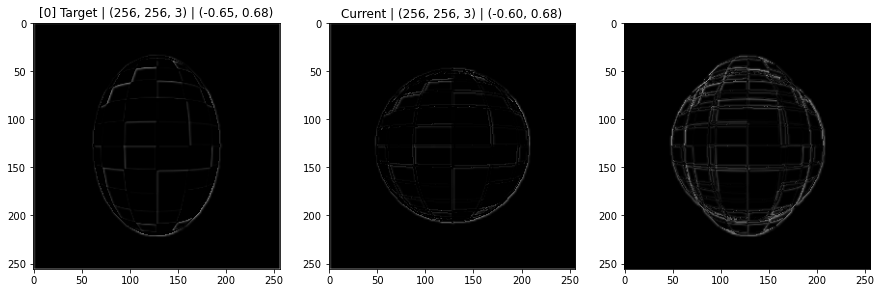

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


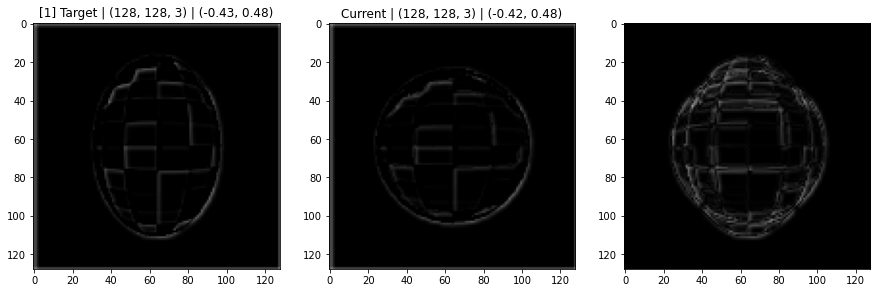

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


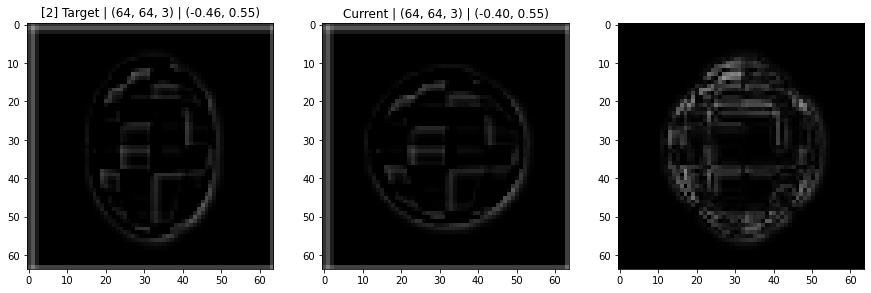

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


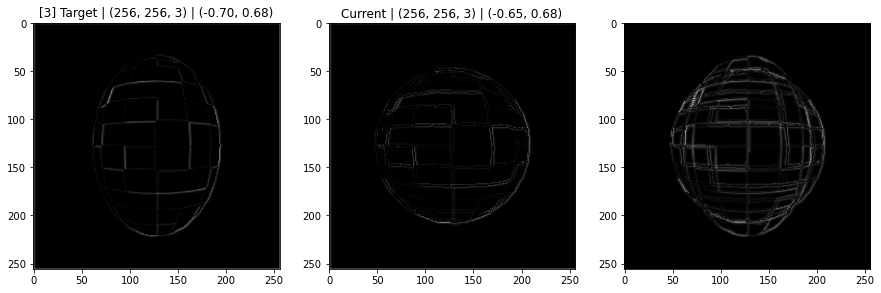

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


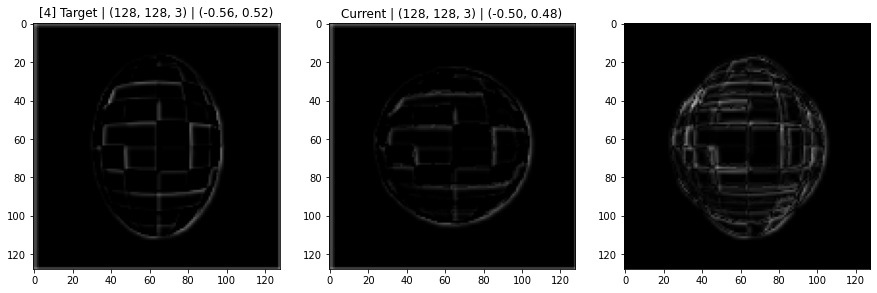

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


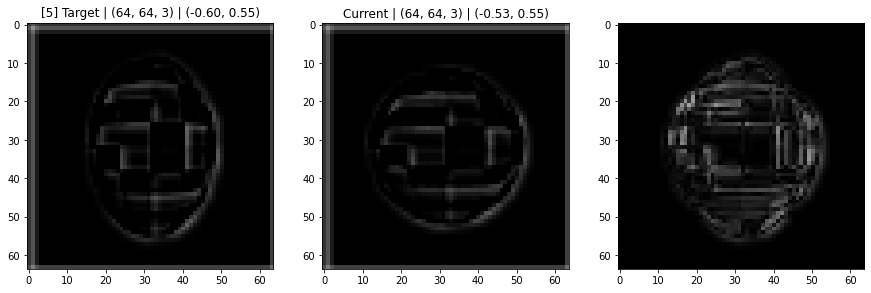

In [108]:
cam_idx = 0
for i, pyramid in enumerate(pyramids):
    ref = pyramid[0][cam_idx].detach().squeeze().cpu().numpy()
    curr = pyramid[1][cam_idx].detach().squeeze().cpu().numpy()
    diff = np.abs(ref-curr)
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(ref, cmap='gray')
    ax[0].set_title('[{}] Target | {} | ({:.2f}, {:.2f})'.format(i, ref.shape, np.min(ref), np.max(ref)))
    ax[1].imshow(curr, cmap='gray')
    ax[1].set_title('Current | {} | ({:.2f}, {:.2f})'.format(curr.shape, np.min(curr), np.max(curr)))
    ax[2].imshow(diff, cmap='gray')
    plt.show()
    

outputs: ./10g_data/output/sphere
##############################
./10_data/input/sphere.obj
##############################
Param_idx=0, total count=1 =====================================================================================
parameters saved to: ./10g_data/output/sphere/setting_0/parameters.json
Log output: ./10g_data/output/sphere/setting_0/log_20200605.txt
self.n_batch: 2


<ipython-input-106-aced2953ff8b>:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  loop = tqdm_notebook(range(1000000000))


Epoch     4: reducing learning rate of group 0 to 7.5000e-03.
Epoch     7: reducing learning rate of group 0 to 5.6250e-03.
Epoch    13: reducing learning rate of group 0 to 4.2188e-03.
Epoch    16: reducing learning rate of group 0 to 3.1641e-03.
Epoch    19: reducing learning rate of group 0 to 2.3730e-03.
Epoch    22: reducing learning rate of group 0 to 1.7798e-03.
Epoch    25: reducing learning rate of group 0 to 1.3348e-03.
Epoch    28: reducing learning rate of group 0 to 1.0011e-03.
Epoch    31: reducing learning rate of group 0 to 7.5085e-04.
Epoch    34: reducing learning rate of group 0 to 5.6314e-04.
Epoch    37: reducing learning rate of group 0 to 4.2235e-04.
Epoch    40: reducing learning rate of group 0 to 3.1676e-04.
Epoch    43: reducing learning rate of group 0 to 2.3757e-04.
Epoch    46: reducing learning rate of group 0 to 1.7818e-04.
Epoch    49: reducing learning rate of group 0 to 1.3363e-04.
Epoch    52: reducing learning rate of group 0 to 1.0023e-04.
Epoch   

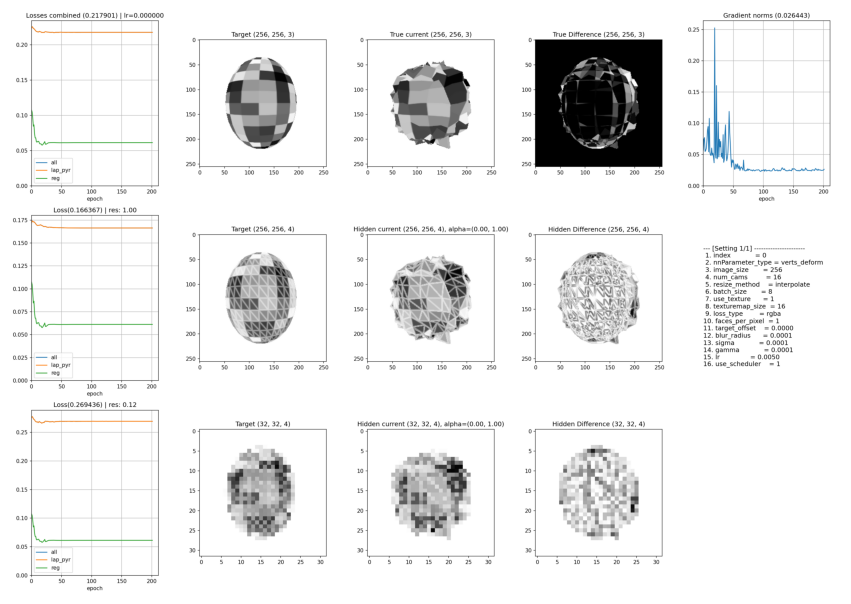

=========== DONE ===========


In [106]:
%matplotlib inline
torch.cuda.empty_cache()
in_dir = './10_data/input'
#obj_names = ['triangle', 'tetrahedron']
obj_names = ['sphere']
mesh_paths = []
for obj_name in obj_names:
    out_dir = './{}/output/{}'.format(out_folder_name, obj_name)
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
    mesh_paths.append(in_dir + '/{}.obj'.format(obj_name))
    print('outputs:', out_dir)

pyramids = []
for mesh_idx, mesh_path in enumerate(mesh_paths):
    print('##############################')
    print(mesh_path)
    print('##############################')
    for param_idx, params in enumerate(p_params):
        print('Param_idx={}, total count={} ====================================================================================='.format(param_idx, len(p_params)))
        out_dir = './{}/output/{}/setting_{}'.format(out_folder_name, obj_names[mesh_idx], param_idx)
        if not os.path.exists(out_dir):
            os.mkdir(out_dir)
        export_params(params, out_dir)
        
#         gif_path = out_dir + '/plots.gif'
        out_path = out_dir + '/plot.png'
        
        # ====================== #
        # start
        now = datetime.now()
        date_str = '{}{:>02}{:>02}'.format(now.year, now.month, now.day)
        log_path = out_dir + '/log_{}.txt'.format(date_str)
        __output_log(log_path, '========== {} Start ==========================\n'.format(date_str))
        __output_log(log_path, params2string(param_idx, len(p_params), params))
#         data_export_path = out_dir + '/data_{}.txt'.format(date_str)
#         data_str = 'timestamp;epoch;loss_true;loss_rgb_true;loss_a_true;loss;loss_rgb;loss_a;grad_vec;grad_norm\n'
#         __output_log(data_export_path, '========== {} Start ==========================\n'.format(date_str))
#         __output_log(data_export_path, data_str)
        print('Log output: {}'.format(log_path))
        
        num_cams = params['num_cams']
        batch_size = params['batch_size']
        loss_type = params['loss_type']
        nnParameter_type = params['nnParameter_type']
        use_texture = params['use_texture']
        image_size = params['image_size']
        resize_method = params['resize_method']
        mesh_target = gen_mesh(mesh_target_path, device, p, deform=False)
        mesh = gen_mesh(mesh_path, device, p, deform=False)
        res = [32/image_size, 1.0]
        model = Model(resize_method=resize_method, device=device, mesh=mesh, mesh_target=mesh_target, nnParameter_type=nnParameter_type, res=res, loss_type=loss_type, n_cams=num_cams, batch_size=batch_size, use_texture=use_texture, image_size=image_size)

        # lr = params['lr']
        lr = 0.01
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=2, verbose=True)
        loop = tqdm_notebook(range(1000000000))

        cam_idx = 2
        
        loss_res_all = []
        loss_res_true_all = []
        grads_all = []
        for _ in range(len(model.res)):
            loss_res_all.append({})
            loss_res_true_all.append({})
        loss_total = {}

        latest_states = {}
        for e in loop:
            t0 = time.time()
            export_plots = (e % 10 == 0)
            lr_curr = optimizer.param_groups[0]['lr']

            loss_res = []
            loss_res_true = []
            images_res = []
            for _ in range(len(model.res)):
                loss_res.append({})
                loss_res_true.append({})
                images_res.append({}) # each element = tensor

            grad_norm_mean = 0.0
            for batch_idx in range(model.n_batch):
                optimizer.zero_grad()
                loss_grad = None
                # ======================================= #
                for res_idx, res in enumerate(model.res):
                    raster_settings.image_size = int(model.image_size * res)
                    
                    image_dict, image_true_dict, loss_dict, loss_true_dict, _ = model(batch_idx=batch_idx, res_idx=res_idx, params=p_params[param_idx])
                    for k, v in loss_dict.items():
                        if v > 0:
                            if k not in loss_res[res_idx]:
                                loss_res[res_idx][k] = 0.0
                            vv = v.detach().cpu().numpy()
                            loss_res[res_idx][k] += vv
                    for k, v in loss_true_dict.items():
                        if v > 0:
                            if k not in loss_res_true[res_idx]:
                                loss_res_true[res_idx][k] = 0.0
                            vv = v.detach().cpu().numpy()
                            loss_res_true[res_idx][k] += loss_true_dict[k].detach().cpu().numpy()
                    # keep images for plotting
                    imgs_curr = image_dict['images'].detach().squeeze().cpu().numpy()
                    imgs_true = image_true_dict['images'].detach().squeeze().cpu().numpy()
                    imgs_target = image_dict['target_images'].detach().squeeze().cpu().numpy()
                    imgs_target_true = image_true_dict['target_images'].detach().squeeze().cpu().numpy()
                    if batch_idx == 0:
                        images_res[res_idx]['images'] = imgs_curr
                        images_res[res_idx]['images_true'] = imgs_true
                        images_res[res_idx]['target_images'] = imgs_target
                        images_res[res_idx]['target_images_true'] = imgs_target_true
                    else:
                        images_res[res_idx]['images'] = np.vstack([images_res[res_idx]['images'], imgs_curr])
                        images_res[res_idx]['images_true'] = np.vstack([images_res[res_idx]['images_true'], imgs_true])
                        images_res[res_idx]['target_images'] = np.vstack([images_res[res_idx]['target_images'], imgs_target])
                        images_res[res_idx]['target_images_true'] = np.vstack([images_res[res_idx]['target_images_true'], imgs_target_true])

                    # keep losses
                    if res_idx == 0:
                        loss_grad = loss_dict['all']
                    else:
                        loss_grad += loss_dict['all']

                loss_grad.backward()
                optimizer.step()
                # ======================================= #
                # keep grads
                grad_norm = None
                grad_value = None
                if nnParameter_type == 'translate':
                    grad_value = model.center_offset.grad.detach().cpu().numpy()
                    grad_norm = np.linalg.norm(grad_value)
                elif nnParameter_type == 'verts_deform':
                    grad_value = model.dverts.grad.detach().cpu().numpy()
                    grad_norm = np.linalg.norm(grad_value)
                grad_norm_mean += (grad_norm / model.n_batch)
            
            scheduler.step(loss_grad)

            # after all batches
            l_total = {}
            for i in range(len(loss_res)):
                for k, v in loss_res[i].items():
                    if k not in loss_res_all[i]:
                        loss_res_all[i][k] = []
                    
                    if k not in l_total:
                        l_total[k] = 0.0
                    loss_res_all[i][k].append(v)
                    l_total[k] += (v / len(loss_res))

                for k, v in loss_res_true[i].items():
                    if k not in loss_res_true_all[i]:
                        loss_res_true_all[i][k] = []
                    loss_res_true_all[i][k].append(v)
                        
            for k, v in l_total.items():
                if k not in loss_total:
                    loss_total[k] = []
                    
                loss_total[k].append(v)
            grads_all.append(grad_norm_mean)

            loop.set_description('p[{}/{}] E[{}] lr({}) loss({:.3f})'.format(param_idx+1, len(p_params), e, lr_curr, loss_res_all[-1]['all'][-1]))

            # =============== #
            # plots
            # =============== #
            if export_plots:
                _ = render_plots_multires(out_dir, e, param_idx, p_params, lr_curr, model.res, cam_idx, images_res, loss_total, loss_res_all, loss_res_true_all, grads_all)
#                 if e == 0:
#                     plt.figure(figsize=(15, 15))
#                     plt.imshow(plot_image)
#                     plt.axis('off')
#                     plt.show()

            # =============== #
            # log
            # =============== #
            t1 = time.time()
            mb_alloc = torch.cuda.memory_allocated() * 0.000001
            mb_cached = torch.cuda.memory_cached() * 0.000001
            now = datetime.now()
            hour = str(now.hour)
            minute = str(now.minute)
            second = str(now.second)
            now_str = '{:>02}:{:>02}:{:>02}'.format(hour, minute, second)
            out_str = '{} | {:04} | {:.2f}s | lr={:.8f} | loss_all_true={:.6f}, loss_all={:.6f} | GPU_allocated({:,.2f}Mb) | GPU_cached({:,.2f}Mb)\n'.format(now_str, e+1, t1-t0, lr_curr, loss_true_dict['all'], loss_dict['all'], mb_alloc, mb_cached)
            __output_log(log_path, out_str)

            # cf) data_str = 'timestamp epoch loss loss_rgb loss_a grad_vec grad_norm\n'
#             grad_value_str = np.array_repr(grad_value).replace('\n', '')
#             data_str = '{};{};{};{};{};{};{};{};{};{}\n'.format(now_str, e, losses_true['all'][-1], losses_true['pixel'][-1], losses_true['silhouette'][-1], losses['all'][-1], losses['pixel'][-1], losses['silhouette'][-1], grad_value_str, grads[-1])
#             __output_log(data_export_path, data_str)

            do_break = False
            if lr_curr < 1e-10:
                print('lr={}. BREAK'.format(lr_curr))
                do_break =  True

            if e > 200:
                print('e={}. BREAK'.format(e))
                do_break = True
                
            if do_break:
                export_losses(loss_total, out_dir)
                
                plot_image = render_plots_multires(out_dir, e, param_idx, p_params, lr_curr, model.res, cam_idx, images_res, loss_total, loss_res_all, loss_res_true_all, grads_all)
                plt.figure(figsize=(15, 15))
                plt.imshow(plot_image)
                plt.axis('off')
                plt.show()
                break
                
print('=========== DONE ===========')

In [ ]:
images[0].save(gif_path, save_all=True, append_images=images[1:], optimize=False, duration=100, loop=0)
print('gif saved:', gif_path)

# Collect final images to a single folder for easy access

In [34]:
import re
from shutil import copyfile
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [99]:
from_dir = './{}/output/{}'.format(out_folder_name, obj_name)
to_dir = from_dir + '/final_plots'
if not os.path.exists(to_dir):
    os.mkdir(to_dir)
    
for setting_idx in range(len(p_params)):
    from_path = from_dir + '/setting_{}'.format(setting_idx)
    pngs = glob.glob(from_path + '/*.png')
    pngs.sort(key=natural_keys)
    last_png_path = pngs[-1]
    epoch_idx = last_png_path.split('plot_')[-1].split('.')[0]
    
    to_path = to_dir + '/setting_{}_epoch{}.png'.format(setting_idx, epoch_idx)
    copyfile(last_png_path, to_path)
    print(last_png_path, '===>', to_path)

./10f_data/output/sphere/setting_0\plot_201.png ===> ./10f_data/output/sphere/final_plots/setting_0_epoch201.png
./10f_data/output/sphere/setting_1\plot_201.png ===> ./10f_data/output/sphere/final_plots/setting_1_epoch201.png
